# Baseline Models

- Using three baseline models for the development of an analysis that detects political language in court documents.
    1. Logistic regression
    2. Naive Bayes
    3. SVM
- Using baselines as a means for testing model performance and building an accurate, model for classifying language used in Bulgaria's constitutional court

## Next steps

- Data needs more sentences labelled as political, as data is imbalanced and models observe few political sentences
- Need to optimize hyperparameters to improve model performance

In [17]:
import glob
import os
import pickle
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, f1_score, plot_roc_curve
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import PrecisionRecallCurve, roc_auc, DiscriminationThreshold

In [18]:
# load all json files in data directory
files = glob.glob("data/json/*.json")
data = []

# for loop for processing files and adding doc id
for json in files:
    frame = pd.read_json(json)
    # get file name as string
    # create column identifying dfs as doc_id
    # split string (remove .json from file name)
    frame["doc_id"] = os.path.splitext(os.path.basename(json))[0]
    data.append(frame)

# concatenate all data frames
df = pd.concat(data, ignore_index=True)

## Cleaning Text

In [19]:
# turn label_id into binary variable
# numpy where function states:
# where label_id is not 4, change to 0, otherwise change to 1

df["label_id"] = np.where(df["label_id"] != 4, 0, 1)


In [20]:
def preprocessing(text):

    text = re.sub("<[^>]*>", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    stop_words = set(stopwords.words("english"))
    words = [word for word in text.lower().split() if not word in stop_words]
    text = " ".join(words)

    return text

In [21]:
df["text"] = df["text"].apply(preprocessing)


In [22]:
ps = PorterStemmer()


def token_ps(text):
    return [ps.stem(word) for word in text.split()]

## Logistic Regression

- Computing a logistic regression model based on the values created from a vectorizer algorithm called tf-idf, which stands for term-frequency inverse document frequency.
- tf-idf measures the originality of the word by comparing how often it appears in a doc with the number of docs the word appears in. The frequency of the words in a doc (compared against other docs) measures the importance of that word in the wider corpus.
- The logistic regression below is computed by building a vector of word values based on the iportance of each word, before using the word vectors to identify the characteristics of the political label to predict which sentences will be political.

In [23]:
# transforming text into vectors
tfidf = TfidfVectorizer(lowercase=False, use_idf=True, norm="l2", smooth_idf=True)
# compute tfidf values for all words in 'text' column of df
X = tfidf.fit_transform(df["text"])
y = df.label_id.values

In [24]:
# splitting data into train and test splits in order to test predictive accuracy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0, shuffle=True
)

In [46]:
# computes and then fits logistic regression that implements cross-validation as a part of the process
# cv = number of cross validation folds
log_reg = LogisticRegressionCV(cv=8, scoring="accuracy", n_jobs=-1)

# fit model
log_reg.fit(X_train, y_train)

# model accuracy
log_predictions = log_reg.predict(X_test)


In [26]:
# defining a function that prints model prediction accuracy
def model_accuracy(name, preds):
    print("---{} Test Set Results---".format(name))
    print("Weighted F1 Average: {}".format(f1_score(y_test, preds, average="weighted")))
    # precision = % predicted accurately
    # recall = % positives identified
    # f1-score = weighted harmonic mean of precision & recall
    # weighted f-1 avg used for comparing classification models
    print(classification_report(y_test, preds))

In [27]:
model_accuracy("Logit", log_predictions)

---Logit Test Set Results---
Weighted F1 Average: 0.8000997426850943
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       127
           1       1.00      0.05      0.09        22

    accuracy                           0.86       149
   macro avg       0.93      0.52      0.51       149
weighted avg       0.88      0.86      0.80       149



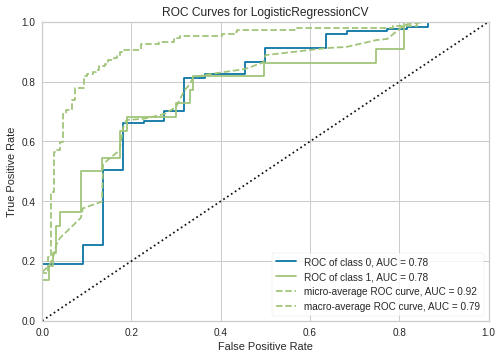

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegressionCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=[0, 1], model=None)

In [28]:
# compute and plot auc-roc curves
# auc = measure of "seperability", roc = probability curve
# the closer the curves are to the top left-hand corner, the better the model

roc_auc(log_reg, X_train, y_train, X_test=X_test, y_test=y_test, classes=[0, 1])


## Naive Bayes

In [29]:
# fit the training dataset on the NB classifier
nb = naive_bayes.ComplementNB()
nb.fit(X_train, y_train)

# model accuracy
nb_predictions = nb.predict(X_test)
model_accuracy("Naive Bayes", nb_predictions)

---Naive Bayes Test Set Results---
Weighted F1 Average: 0.8372325419305285
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       127
           1       0.47      0.36      0.41        22

    accuracy                           0.85       149
   macro avg       0.68      0.65      0.66       149
weighted avg       0.83      0.85      0.84       149



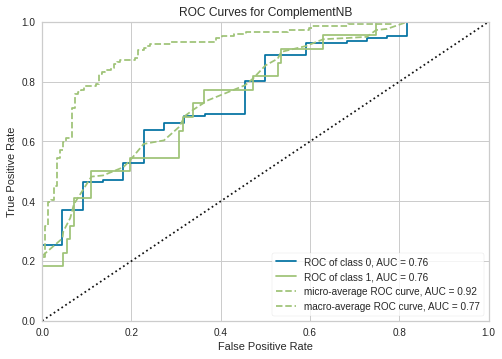

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for ComplementNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=None, classes=[0, 1], model=None)

In [30]:
roc_auc(nb, X_train, y_train, X_test=X_test, y_test=y_test, classes=[0, 1])

## Support Vector Machines (SVM)

In [31]:
# fit the training dataset on the SVM classifier
SVM = svm.SVC(C=1, kernel="linear", class_weight="balanced")
SVM.fit(X_train, y_train)

# model accuracy
svm_predictions = SVM.predict(X_test)
model_accuracy("SVM", svm_predictions)

---SVM Test Set Results---
Weighted F1 Average: 0.8147422394225902
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       127
           1       1.00      0.09      0.17        22

    accuracy                           0.87       149
   macro avg       0.93      0.55      0.55       149
weighted avg       0.88      0.87      0.81       149



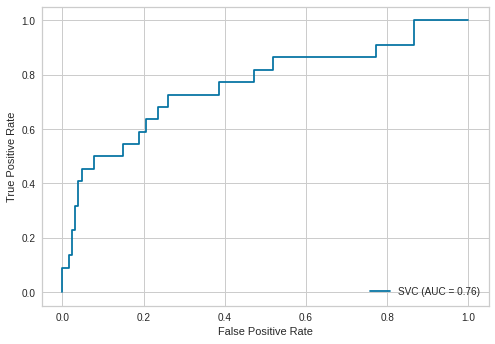

In [32]:
# error plotting yb method, using sklearn instead
## TODO - solve error and plot using more detailed yb method
plot_roc_curve(SVM, X_test, y_test)

## Pickling Models (for Future Use)

In [33]:
# saving tfidf
pickle.dump(tfidf, open("tfidf.pickle", "wb"))

# saving models
pickle.dump(log_reg, open("log_reg.pickle", "wb"))
pickle.dump(nb, open("nb.pickle", "wb"))
pickle.dump(SVM, open("svm.pickle", "wb"))


## Comparing Model Performance

- Precision-Recall Curve - a measure of prediction success when classes are very imbalanced, as is the case in this data.
  - Plots the tradeoff between the precision (% predicted accurately) and recall (% positives identified).
  - Also plots average precision, which is the weighted average of precision achieved at each threshold.
    - Average precision also represents the area under the curve, so can be treated as a composite measure of performance.
  - The goal is to maximize both precision and recall, which would mean that the model is predicting accurately for the majority of classes it selects. When this is the case, the area under the curve would be greater.
- Discrimination Threshold - the probability or score at which the positive class is chosen over the negative class.
  - Plots the precision, recall, f1 score, and queue rate with respect to the discrimination threshold of a binary classifier.

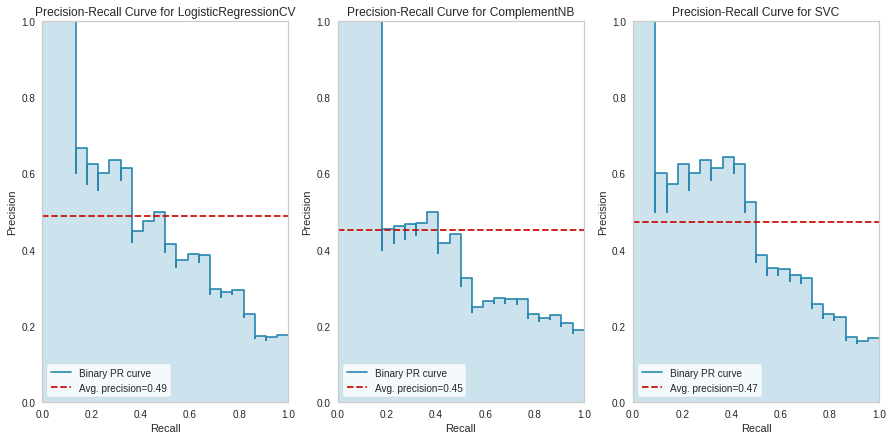

In [41]:
# Create the visualizers, fit, score, and show them

models = [log_reg, nb, SVM]
_, axes = plt.subplots(ncols=3, figsize=(15, 7))

for idx, ax in enumerate(axes.flatten()):
    viz = PrecisionRecallCurve(models[idx], ax=ax, show=False)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()

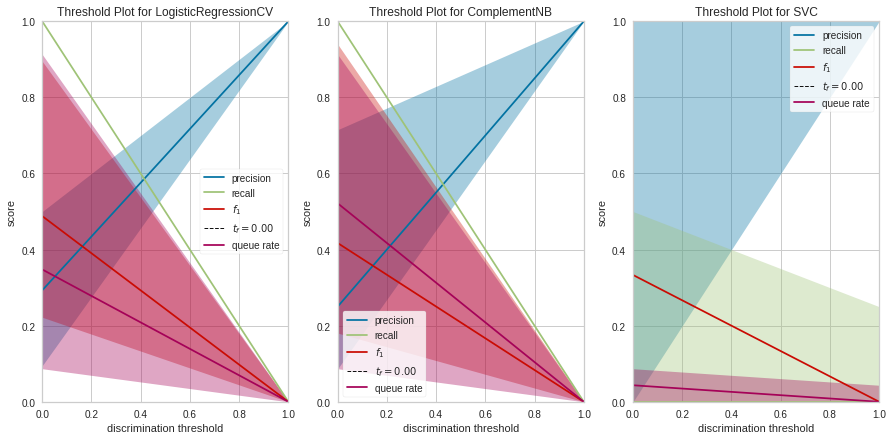

In [47]:
# Create the visualizers, fit, score, and show them

models = [log_reg, nb, SVM]
_, axes = plt.subplots(ncols=3, figsize=(15, 7))

for idx, ax in enumerate(axes.flatten()):
    viz = DiscriminationThreshold(models[idx], ax=ax, show=False)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()